# Pràctica 1: Identificació d'idioma

In [1]:
import re
import os
import glob
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score
from nltk import ngrams
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

## 1. Preprocessing

Creem funcions per carregar les nostres dades i preprocessar-les tal com se'ns demana.

In [2]:
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # Elimina los dígitos
    text = text.lower()  # Convierte a minúsculas
    text = re.sub(r'\s+', ' ', text)  # Reemplaza espacios múltiples por uno solo
    text = re.sub(r'\n', '  ', text)  # Espai doble entre frases    
    return text

In [3]:
def create_trigrams(text):
    characters = [char for char in text]
    return [''.join(trigram) for trigram in ngrams(characters, 3) if len(trigram) == 3]

In [4]:
def filter_infrequent_trigrams(texts):
    trigram_counts = Counter(' '.join(texts).split()) 
    frequent_trigrams = {trigram for trigram, count in trigram_counts.items() if count >= 5}
    filtered_texts = [' '.join([trigram for trigram in text.split() if trigram in frequent_trigrams]) for text in texts]
    return filtered_texts

## 2. Creació dels models

### 2.1. Llei de Lidstone (LID)

In [5]:
import random

def load_data_train_val(filenames):
    train_data = {}
    val_data = {}

    for file in filenames:
        with open(file, 'r', encoding='utf-8') as f:
            text = preprocess_text(f.read())
            trigrams = create_trigrams(text)
            filename = os.path.basename(file).split('_')[0]
            
            train_data[filename] = trigrams.copy()
            # Separar aleatoriamente el 30% de los trigramas para validación
            random.shuffle(trigrams)
            split_index = int(len(trigrams) * 0.7)
            val_trigrams = trigrams[:split_index]
            val_data[filename] = val_trigrams

    return train_data, val_data

# Function to load the test data from the files

def load_data_test(filenames):
    texts = []
    labels = []
    for file in filenames:
        label = os.path.basename(file).split('_')[0]  # The tag is the first part of the filename
        with open(file, 'r', encoding='utf-8') as f:
            for line in f:
                texts.append(line.strip())
                labels.append(label)
    return texts, labels


In [6]:
# Carreguem les dades
train_files = glob.glob('langId/*_trn.txt')
test_files = glob.glob('langId/*_tst.txt')

# Preprocessem les dades
train_data, val_data = load_data_train_val(train_files)
X_test, y_test = load_data_test(test_files)

In [7]:
def filter_infrequent_trigramsDICT(list_trigrams):
    # Contar la frecuencia de cada trigram en la lista
    trigram_counts = Counter(list_trigrams)
    
    # Seleccionar los trigramas que aparecen al menos 5 veces
    frequent_trigrams = {trigram for trigram, count in trigram_counts.items() if count >= 5}
    
    # Filtrar la lista de trigramas para incluir solo los trigramas frecuentes
    filtered_list_trigrams = [trigram for trigram in list_trigrams if trigram in frequent_trigrams]
    
    return filtered_list_trigrams


In [8]:
for key in train_data:
    # aplicar filter_infrequent_trigrams al valor de cada key
    train_data[key] = filter_infrequent_trigramsDICT(train_data[key])
    val_data[key] = filter_infrequent_trigramsDICT(val_data[key])

In [9]:
# Funció que retorna el nombre de trigrames que apareixen en una llista de trigrames
def count_trigrams(trigram, list_trigrams):
    freq_trigram = {}
    for t in list_trigrams:
        freq_trigram[t] = freq_trigram.get(t, 0) + 1
    return freq_trigram.get(trigram, 0)

# Fem un diccionari que, per a cada idioma, conté la seva variable B i NT
info_lang = {}
for lang, trigrams in train_data.items():
    NT = len(trigrams)
    B = 30**3 # editar B per a cada idioma
    info_lang[lang] = {'NT': NT, 'B': B}

In [10]:
# Funció LID

def LID(count_trigram, NT, B, lam=0.5):
    result_LID = np.log((count_trigram + lam) / (NT + lam * B))
    return result_LID


In [11]:
# Funció de normalització de valors entre 0 i 1
def min_max_normalization(data):
    min_val = min(data.values())
    max_val = max(data.values())
    normalized_data = {}

    for key, value in data.items():
        normalized_value = (value - min_val) / (max_val - min_val)
        normalized_data[key] = normalized_value

    return normalized_data

In [12]:
def create_probability_dict(data, lam=0.5):

    trigram_counts = {}  # Creamos un diccionario vacío para almacenar los recuentos de trigramas

    # Iteramos sobre cada par (lang, trigrams) en los datos de entrenamiento
    for lang, lang_trigrams in data.items():
        # Iteramos sobre cada trigram en la lista de trigramas del idioma actual
        for trigram in lang_trigrams:
            # Si el trigram no está en el diccionario principal, lo agregamos
            if trigram not in trigram_counts:
                trigram_counts[trigram] = {'deu': 0, 'eng': 0, 'fra': 0, 'ita': 0, 'nld': 0, 'spa': 0}
            # Incrementamos el recuento del trigram actual en el idioma actual
            trigram_counts[trigram][lang] += 1          

    trigram_LID = {}  # Creamos un diccionario vacío para almacenar los LID de trigramas

    # Iteramos sobre cada trigram y sus recuentos por idioma en el diccionario de recuentos de trigramas
    for trigram, lang_counts in trigram_counts.items():
        trigram_lang_LID = {}  # Creamos un diccionario vacío para almacenar los LID de trigramas por idioma
        # Iteramos sobre cada idioma y su recuento en los recuentos del trigram actual
        for lang, count in lang_counts.items():
            # Calculamos el LID de trigramas para el trigram actual en el idioma actual
            trigram_lang_LID[lang] = LID(count, info_lang[lang]['NT'], info_lang[lang]['B'], lam)
        # Agregamos los LID de trigramas por idioma para el trigram actual al diccionario principal
        trigram_LID[trigram] = trigram_lang_LID

    return trigram_LID


In [13]:
# Funció que, donat un text, retorna el LID per a cada idioma: {'idioma1': LID, 'idioma2': LID, ...}. Per fer això, sumem els LID de cada trigrama del text per a cada idioma
def predict_language(text, trigram_LID, lam=0.5):
    treated_text = preprocess_text(text)  # Preprocessem el text
    trigrams_text = create_trigrams(treated_text) # Creem els trigrames del text
    LID_per_lang = {}
    for trigram in trigrams_text:
        if trigram in trigram_LID:
            LID_per_lang_trigram = trigram_LID[trigram] # Obtenim el LID per a cada idioma per a cada trigrama

        else:
            #calculem un LID per a cada idioma amb conteig de 0 en tots els idiomes
            LID_per_lang_trigram = {}
            for lang in info_lang:
                LID_per_lang_trigram[lang] = LID(0, info_lang[lang]['NT'], info_lang[lang]['B'], lam)

        for lang, LID_trigram in LID_per_lang_trigram.items(): 
            LID_per_lang[lang] = LID_per_lang.get(lang, 0) + LID_trigram # Sumem els LID de cada trigrama per a cada idioma
    normalized_LID_per_lang = min_max_normalization(LID_per_lang)  # Normalitzem els valors de LID entre 0 i 1
    max_language = max(normalized_LID_per_lang, key=normalized_LID_per_lang.get)  # Obtenim l'idioma amb el LID més alt

    return normalized_LID_per_lang, max_language

In [14]:
def evaluate_results(X_test, y_test, trigram_LID, lam=0.5):
    y_pred = []
    for sentence in X_test:
        _, lang = predict_language(sentence, trigram_LID, lam)
        y_pred.append(lang)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, precision, f1, conf_matrix

# VALIDATION

In [15]:
lambdas = [0.1, 0.3, 0.5, 0.7, 1]
Bs = [25**3, 26**3, 27**3, 30**3, 33**3]
best_hyper = (lambdas[0], Bs[0])
best_f1_score = 0


for lam in lambdas:
    for B in Bs:
        for lang in info_lang:
            info_lang[lang]['B'] = B
        val_trigram_LID = create_probability_dict(train_data, lam)
        accuracy, precision, f1, conf_matrix = evaluate_results(X_test, y_test, val_trigram_LID, lam)
        if f1 >= best_f1_score:
            best_f1_score = f1
            best_hyper = (lam, B)

best_lambda = best_hyper[0]
best_B = best_hyper[1]

for lang in info_lang:
    info_lang[lang]['B'] = best_B

print(f'Best lambda: {best_hyper} with F1 score: {best_f1_score}')

Best lambda: (1, 35937) with F1 score: 0.9989162728065941


# TRAIN

In [16]:
trigram_LID = create_probability_dict(train_data, best_lambda)

### EXAMPLE OF PREDICTING THE LANGUAGE OF A SENTENCE

In [17]:
#Exemple d'ús de la funció predict_language
text = 'Aan de achterzijde van de Hermitage Amsterdam liggen aan Nieuwe Herengracht de monumentale huizen: Het Corvershof'

print(predict_language(text, trigram_LID, best_lambda))

({'deu': 0.49692681695880625, 'eng': 0.2994069999873196, 'fra': 0.2229561662185842, 'ita': 0.0, 'nld': 1.0, 'spa': 0.09044880193587693}, 'nld')


# EVALUATE FINAL RESULTS

Accuracy: 0.998916251229638
Precision: [0.9989992  0.99740286 0.99939964 0.99919952 0.99909883 0.99939994]
F1 score: 0.9989162728065941


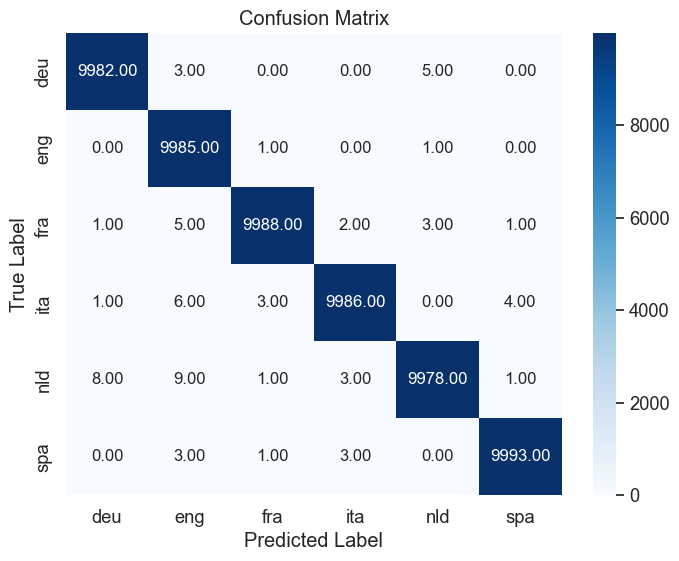

In [18]:
# Prediccions per a les dades de test i càlcul de l'accuracy i la matriu de confusió


accuracy, precision, f1, conf_matrix = evaluate_results(X_test, y_test, trigram_LID, best_lambda)


print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'F1 score: {f1}')

# Define las etiquetas de las clases
classes = np.unique(y_test)


# Grafica la matriz de confusión
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 12}, cmap="Blues", fmt=".2f", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()